Run timeseries simulations
======================

In this section, we will learn how to:

- run timeseries simulations using the ``PVEngine`` class, and visualize some of the results
- run timeseries simulations using the ``run_timeseries_engine()`` function

Imports and settings

In [1]:
# Import external libraries
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd
import warnings

# Settings
%matplotlib inline
np.set_printoptions(precision=3, linewidth=300)
warnings.filterwarnings('ignore')
# Paths
LOCAL_DIR = os.getcwd()
DATA_DIR = os.path.join(LOCAL_DIR, 'data')
filepath = os.path.join(DATA_DIR, 'test_df_inputs_MET_clearsky_tucson.csv')

### Get timeseries inputs

In [2]:
def export_data(fp):
    tz = 'US/Arizona'
    df = pd.read_csv(fp, index_col=0)
    df.index = pd.DatetimeIndex(df.index).tz_convert(tz)
    return df

df = export_data(filepath)
df_inputs = df.iloc[:24, :]

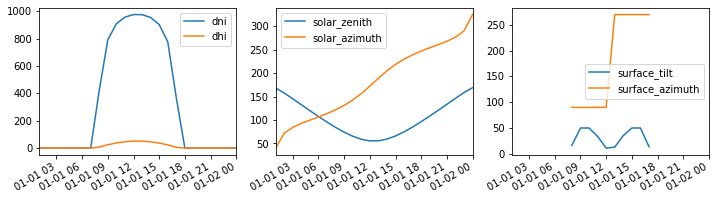

In [3]:
# Plot the data
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 3))
df_inputs[['dni', 'dhi']].plot(ax=ax1)
df_inputs[['solar_zenith', 'solar_azimuth']].plot(ax=ax2)
df_inputs[['surface_tilt', 'surface_azimuth']].plot(ax=ax3)
plt.show()

In [4]:
# Use a fixed albedo
albedo = 0.2

### Prepare PV array parameters

In [5]:
pvarray_parameters = {
    'n_pvrows': 3,            # number of pv rows
    'pvrow_height': 1,        # height of pvrows (measured at center / torque tube)
    'pvrow_width': 1,         # width of pvrows
    'axis_azimuth': 0.,       # azimuth angle of rotation axis
    'gcr': 0.4,               # ground coverage ratio
    'rho_front_pvrow': 0.01,  # pv row front surface reflectivity
    'rho_back_pvrow': 0.03,   # pv row back surface reflectivity
}

### Run single timestep with PVEngine and inspect results

Instantiate the ``PVEngine`` class and fit it to the data

In [6]:
from pvfactors.engine import PVEngine
from pvfactors.geometry import OrderedPVArray

# Create ordered PV array
pvarray = OrderedPVArray.init_from_dict(pvarray_parameters)
# Create engine
engine = PVEngine(pvarray)
# Fit engine to data
engine.fit(df_inputs.index, df_inputs.dni, df_inputs.dhi, 
           df_inputs.solar_zenith, df_inputs.solar_azimuth, 
           df_inputs.surface_tilt, df_inputs.surface_azimuth, 
           albedo)

The user can run a simulation for a single timestep and plot the returned PV array

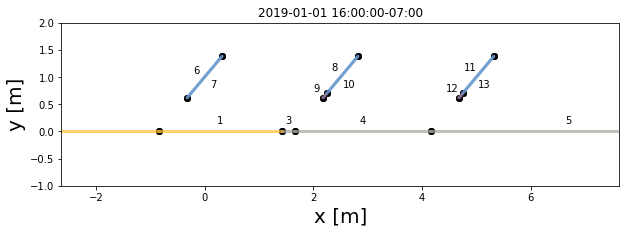

In [7]:
# Get pvarray at given timestamp
pvarray = engine.run_timestep(idx=15)

# Plot pvarray shapely geometries
f, ax = plt.subplots(figsize=(10, 3))
pvarray.plot(ax, with_index=True)
ax.set_title(df.index[15])
plt.show()

The user can also visualize the view factor matrix calculated for the timestamp

In [8]:
pvarray.vf_matrix

array([[0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.002, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.998],
       [0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.239, 0.03 , 0.005, 0.   , 0.012, 0.001, 0.   , 0.712],
       [0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.001, 0.999],
       [0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.144, 0.015, 0.004, 0.   , 0.019, 0.002, 0.   , 0.816],
       [0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.058, 0.   , 0.   , 0.23 , 0.029, 0.005, 0.   , 0.679],
       [0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.004, 0.   , 0.   , 0.032, 0.   , 0.   , 0.143, 0.82 ],
       [0.175, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.825],
       [0.   , 0.54 , 0.004, 0.035, 0.144, 0.022, 0.   , 0.   , 0.104, 0.018, 0.   , 0.   , 0.   , 0.   , 0.133],
       [0.047, 0.077, 0.   , 0.004, 0.   , 0.   , 0.   , 0.117, 0.   , 0.   , 0.   , 0. 

The user can inspect the results very easily thanks to the simple geometry API

In [9]:
# Get the calculated outputs from the pv array
center_row_front_incident_irradiance = pvarray.pvrows[1].front.get_param_weighted('qinc')
left_row_back_reflected_incident_irradiance = pvarray.pvrows[0].back.get_param_weighted('reflection')
right_row_back_isotropic_incident_irradiance = pvarray.pvrows[2].back.get_param_weighted('isotropic')

print("Incident irradiance on front surface of middle pv row: %.2f W/m2"
      % center_row_front_incident_irradiance)
print("Reflected irradiance on back surface of left pv row: %.2f W/m2"
      % left_row_back_reflected_incident_irradiance)
print("Isotropic irradiance on back surface of right pv row: %.2f W/m2"
      % right_row_back_isotropic_incident_irradiance)

Incident irradiance on front surface of middle pv row: 550.17 W/m2
Reflected irradiance on back surface of left pv row: 25.22 W/m2
Isotropic irradiance on back surface of right pv row: 2.83 W/m2


### Run multiple timesteps with PVEngine

The users can also run simulations for all timestamps, and obtain a "report" that will look like whatever the users want, and which will rely on the simple geometry API shown above.
Here is an example:

In [10]:
# Create a function that will build a report
from pvfactors.report import example_fn_build_report

# Run full simulation
report = engine.run_all_timesteps(fn_build_report=example_fn_build_report)

# Print results (report is defined by report function passed by user)
df_report = pd.DataFrame(report, index=df_inputs.index)
df_report.iloc[6:11]

100%|██████████| 24/24 [00:00<00:00, 56.57it/s]


,qinc_front,qinc_back,iso_front,iso_back
2019-01-01 07:00:00-07:00,NaN,NaN,NaN,NaN
2019-01-01 08:00:00-07:00,117.632919,9.703829,5.070103,0.076232
2019-01-01 09:00:00-07:00,587.344229,4.959138,12.087407,2.150237
2019-01-01 10:00:00-07:00,685.115436,33.478098,17.516188,3.115967
2019-01-01 11:00:00-07:00,652.526254,52.534503,24.250780,1.697046


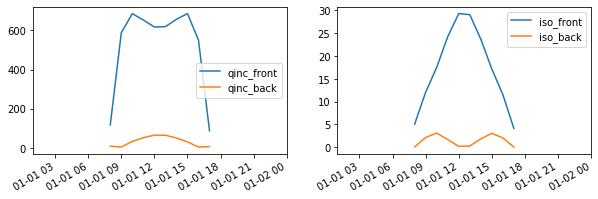

In [11]:
f, ax = plt.subplots(1, 2, figsize=(10, 3))
df_report[['qinc_front', 'qinc_back']].plot(ax=ax[0])
df_report[['iso_front', 'iso_back']].plot(ax=ax[1])
plt.show()

A function that builds a report needs to be specified, otherwise nothing will be returned by the simulation.  
Here is an example of a report function that will return the total incident irradiance (``'qinc'``) on the back surface of the rightmost PV row.
A good way to get started building the reporting function is to use the example provided in the ``report.py`` module of the pvfactors package.

In [12]:
def new_fn_build_report(report, pvarray):
    # Initialize the report as a dictionary
    if report is None:
        list_keys = ['total_inc_back']
        report = {key: [] for key in list_keys}
    # Add elements to the report
    if pvarray is not None:
        pvrow = pvarray.pvrows[-1]  # use rightmost pvrow
        report['total_inc_back'].append(
            pvrow.back.get_param_weighted('qinc'))
    else:
        # No calculation was performed, because sun was down
        report['total_inc_back'].append(np.nan)

    return report

Now we can run the timeseries simulation again using the same engine but a different report function.

In [13]:
# Run full simulation using new report function
new_report = engine.run_all_timesteps(fn_build_report=new_fn_build_report)

# Print results
df_new_report = pd.DataFrame(new_report, index=df_inputs.index)
df_new_report.iloc[6:11]

100%|██████████| 24/24 [00:00<00:00, 65.54it/s]


,total_inc_back
2019-01-01 07:00:00-07:00,NaN
2019-01-01 08:00:00-07:00,9.901971
2019-01-01 09:00:00-07:00,28.275688
2019-01-01 10:00:00-07:00,36.479082
2019-01-01 11:00:00-07:00,52.169775


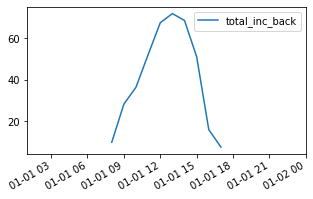

In [14]:
f, ax = plt.subplots(figsize=(5, 3))
df_new_report.plot(ax=ax)
plt.show()

We can see in the printed output the new report generated by the simulation run.  
For convenience, we've been using dictionaries as the data structure holding the reports, but it could be anything else, like numpy arrays, pandas dataframes, etc.

### Run one or multiple timesteps with the ``run_timeseries_engine()`` function

The same thing can be accomplished using a function from the ``run.py`` module of the pvfactors package.  
But only the report will be returned.

In [15]:
# import function
from pvfactors.run import run_timeseries_engine

# run simulation using new_fn_build_report
report_from_fn = run_timeseries_engine(new_fn_build_report, pvarray_parameters, df_inputs.index, 
                                       df_inputs.dni, df_inputs.dhi, 
                                       df_inputs.solar_zenith, df_inputs.solar_azimuth, 
                                       df_inputs.surface_tilt, df_inputs.surface_azimuth, 
                                       albedo)

# make a dataframe out of the report
df_report_from_fn = pd.DataFrame(report_from_fn, index=df_inputs.index)

100%|██████████| 24/24 [00:00<00:00, 69.52it/s]


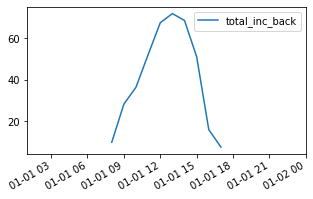

In [16]:
f, ax = plt.subplots(figsize=(5, 3))
df_report_from_fn.plot(ax=ax)
plt.show()

The plot above shows that we get the same results as previously.